In [1]:
import kagglehub
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import torch.nn as nn
import torch
from PIL import Image
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import hashlib
import cv2
import random
from torch.amp import autocast, GradScaler

torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = "cuda" if torch.cuda.is_available() else "cpu"

def set_global_seed(seed: int = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = False

    try:
        import cv2
        cv2.setRNGSeed(seed)
    except:
        pass

set_global_seed(42)

c:\Users\TUF Gaming\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomDataset(Dataset):
    """ 
    Custom Dataset that loads all pictures into the memory at the start.
    """
    def __init__(self, root):
        self.class_names = sorted(os.listdir(root))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}
        self.paths = sorted(glob(f"{root}/*/*"))

        print("Loading in ram...")
        self.images = []
        self.labels = []

        for i, path in enumerate(self.paths):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            label_name = os.path.basename(os.path.dirname(path))
            label = self.class_to_idx[label_name]

            self.images.append(img)
            self.labels.append(label)

            if i % 500 == 0:
                print(f"{i}/{len(self.paths)} pictures loaded...")

        print(f"Loading completed. {len(self.images)} pictures loaded.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


root = os.path.join("Lung X-Ray Image", "Lung X-Ray Image")

dataset = CustomDataset(root)
num_classes = len(dataset.class_names)

Loading in ram...
0/3319 pictures loaded...
500/3319 pictures loaded...
1000/3319 pictures loaded...
1500/3319 pictures loaded...
2000/3319 pictures loaded...
2500/3319 pictures loaded...
3000/3319 pictures loaded...
Loading completed. 3319 pictures loaded.


In [3]:
class TransformDataset(Dataset):
    """" 
    This wrapper applies transformations on-the-fly to the existing dataset.
    """
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        
        if self.transform:
            img = self.transform(img)
        return img, label

In [5]:
class CLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8), p=0.5):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            if isinstance(img, torch.Tensor):
                img_np = img.permute(1, 2, 0).numpy()
                img_np = (img_np * 255).astype(np.uint8)
            else:
                img_np = np.array(img)
            
            clahe = cv2.createCLAHE(
                clipLimit=self.clip_limit,
                tileGridSize=self.tile_grid_size
            )
            
            if len(img_np.shape) == 3:
                img_clahe = np.zeros_like(img_np)
                for i in range(img_np.shape[2]):
                    img_clahe[:, :, i] = clahe.apply(img_np[:, :, i])
            else:
                img_clahe = clahe.apply(img_np)
            
            img = torch.from_numpy(img_clahe).float() / 255.0
            if len(img_clahe.shape) == 3:
                img = img.permute(2, 0, 1)
        
        return img

class GaussianNoise:
    def __init__(self, mean=0.0, std=0.02, p=0.3):
        self.mean = mean
        self.std = std
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            noise = torch.randn_like(img) * self.std + self.mean
            img = img + noise
            img = torch.clamp(img, 0.0, 1.0)
        return img

class RandomGamma:
    def __init__(self, gamma_range=(0.8, 1.2), p=0.5):
        self.gamma_range = gamma_range
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            gamma = random.uniform(*self.gamma_range)
            img = torch.pow(img, gamma)
        return img

In [6]:
train_transform = T.Compose([
    CLAHE(clip_limit=2.5, tile_grid_size=(8, 8), p=0.6),
    T.ColorJitter(brightness=0.25, contrast=0.25),
    RandomGamma(gamma_range=(0.8, 1.2), p=0.5),
    GaussianNoise(mean=0.0, std=0.02, p=0.3),
    T.Normalize(mean=[0.5], std=[0.5])
])

val_transform = T.Compose([
    CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    T.Normalize(mean=[0.5], std=[0.5])
])

test_transform = T.Compose([
    CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    T.Normalize(mean=[0.5], std=[0.5])
])

In [7]:
total = len(dataset)
test_size = int(0.15 * total)
val_size = int(0.15 * total)
train_size = total - val_size - test_size

train_base, val_base, test_base = random_split(dataset, [train_size, val_size, test_size])

train_dataset = TransformDataset(train_base, transform=train_transform)
val_dataset   = TransformDataset(val_base,   transform=val_transform)
test_dataset  = TransformDataset(test_base,  transform=test_transform)

In [8]:
class MLP(nn.Module):
    def __init__(self, num_classes, input_size=299, dropout=0.3):
        super().__init__()

        flattened_input = 3 * input_size * input_size

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_input, 200),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(100, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [9]:
def train_one_epoch(model, loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        
        with autocast(device):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.detach()

    return (running_loss / len(loader)).item()


def validate(model, loader, criterion, device):
    model.eval()
    total_correct = 0
    running_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with autocast(device):
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.detach()
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == labels).sum()
            total_samples += labels.size(0)

    avg_loss = (running_loss / len(loader)).item()
    accuracy = (total_correct / total_samples).item()
    
    return avg_loss, accuracy

### Hyper parameter search

In [8]:
import itertools

def hyperparameter_search(train_loader, val_loader, num_classes, device):
    print("Search start. Device:", device)

    param_grid = {
        "lr": [1e-3, 5e-4],
        "optimizer": ["adam", "sgd"],
        "dropout": [0.3, 0.5]
    }

    best_acc = 0
    best_params = None
    best_model_state = None

    scaler = torch.amp.GradScaler('cuda')

    for lr, opt_name, dropout in itertools.product(
        param_grid["lr"],
        param_grid["optimizer"],
        param_grid["dropout"]
    ):
        print(f"\nTest hyper-params : lr={lr}, optimizer={opt_name}, dropout={dropout}")

        model = MLP(num_classes, input_size=299, dropout=dropout).to(device)

        criterion = nn.CrossEntropyLoss()

        if opt_name == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        else:
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        for epoch in range(20): 
            train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler)
            val_loss, val_acc = validate(model, val_loader, criterion, device)
            print(f"Epoch {epoch+1}: val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_params = {"lr": lr, "optimizer": opt_name, "dropout": dropout}
            best_model_state = model.state_dict()

    return best_params, best_acc, best_model_state


In [9]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

best_params, best_acc, best_state = hyperparameter_search(
    train_loader,
    val_loader,
    num_classes,
    device
)
print("Best parameters found :", best_params)
print(f"Best val accuracy: {best_acc:.4f}")

Search start. Device: cuda

Test hyper-params : lr=0.001, optimizer=adam, dropout=0.3
Epoch 1: val_loss=0.8951, val_acc=0.7635
Epoch 2: val_loss=0.5124, val_acc=0.8058
Epoch 3: val_loss=0.5518, val_acc=0.7481
Epoch 4: val_loss=0.4928, val_acc=0.7923
Epoch 5: val_loss=0.5159, val_acc=0.7673
Epoch 6: val_loss=0.4600, val_acc=0.8077
Epoch 7: val_loss=0.5397, val_acc=0.7923
Epoch 8: val_loss=0.4649, val_acc=0.8096
Epoch 9: val_loss=0.4901, val_acc=0.8115
Epoch 10: val_loss=0.4615, val_acc=0.8231
Epoch 11: val_loss=0.4868, val_acc=0.8058
Epoch 12: val_loss=0.4692, val_acc=0.8327
Epoch 13: val_loss=0.4183, val_acc=0.8365
Epoch 14: val_loss=0.4354, val_acc=0.8250
Epoch 15: val_loss=0.4401, val_acc=0.8173
Epoch 16: val_loss=0.4326, val_acc=0.8327
Epoch 17: val_loss=0.4226, val_acc=0.8327
Epoch 18: val_loss=0.4307, val_acc=0.8346
Epoch 19: val_loss=0.3975, val_acc=0.8423
Epoch 20: val_loss=0.3950, val_acc=0.8481

Test hyper-params : lr=0.001, optimizer=adam, dropout=0.5
Epoch 1: val_loss=0.7519

Best parameters :
- lr = 0.001
- optimizer = Adam
- dropout = 0.3

# Training model on best parameters

In [17]:
if device == 'cuda':
    torch.cuda.empty_cache()


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

mlp = MLP(num_classes, input_size=299, dropout=0.3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(mlp.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = torch.amp.GradScaler('cuda')

train_losses = []
val_losses = []
val_accuracies = []

best_val_loss = 100.0
best_epoch = 0

num_epochs = 25

for epoch in range(num_epochs):
    train_loss = train_one_epoch(mlp, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc = validate(mlp, val_loader, criterion, device)

    scheduler.step(val_loss)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        torch.save(mlp.state_dict(), "saved_models/mlp.pth")
        print(f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f} | New best saved.")
    else:
        print(f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

if device == 'cuda':
    torch.cuda.empty_cache()


Epoch 1/25: train_loss=3.0351, val_loss=0.6392, val_acc=0.7646 | New best saved.
Epoch 2/25: train_loss=0.9674, val_loss=0.4990, val_acc=0.8109 | New best saved.
Epoch 3/25: train_loss=0.6752, val_loss=0.5336, val_acc=0.8129
Epoch 4/25: train_loss=0.5386, val_loss=0.4785, val_acc=0.8290 | New best saved.
Epoch 5/25: train_loss=0.4808, val_loss=0.4642, val_acc=0.8270 | New best saved.
Epoch 6/25: train_loss=0.4384, val_loss=0.4428, val_acc=0.8370 | New best saved.
Epoch 7/25: train_loss=0.4470, val_loss=0.4367, val_acc=0.8390 | New best saved.
Epoch 8/25: train_loss=0.3993, val_loss=0.4361, val_acc=0.8129 | New best saved.
Epoch 9/25: train_loss=0.4324, val_loss=0.4025, val_acc=0.8270 | New best saved.
Epoch 10/25: train_loss=0.3713, val_loss=0.4184, val_acc=0.8229
Epoch 11/25: train_loss=0.3865, val_loss=0.4189, val_acc=0.8330
Epoch 12/25: train_loss=0.3643, val_loss=0.4202, val_acc=0.8270
Epoch 13/25: train_loss=0.3238, val_loss=0.3821, val_acc=0.8350 | New best saved.
Epoch 14/25: tr

### Learning curves

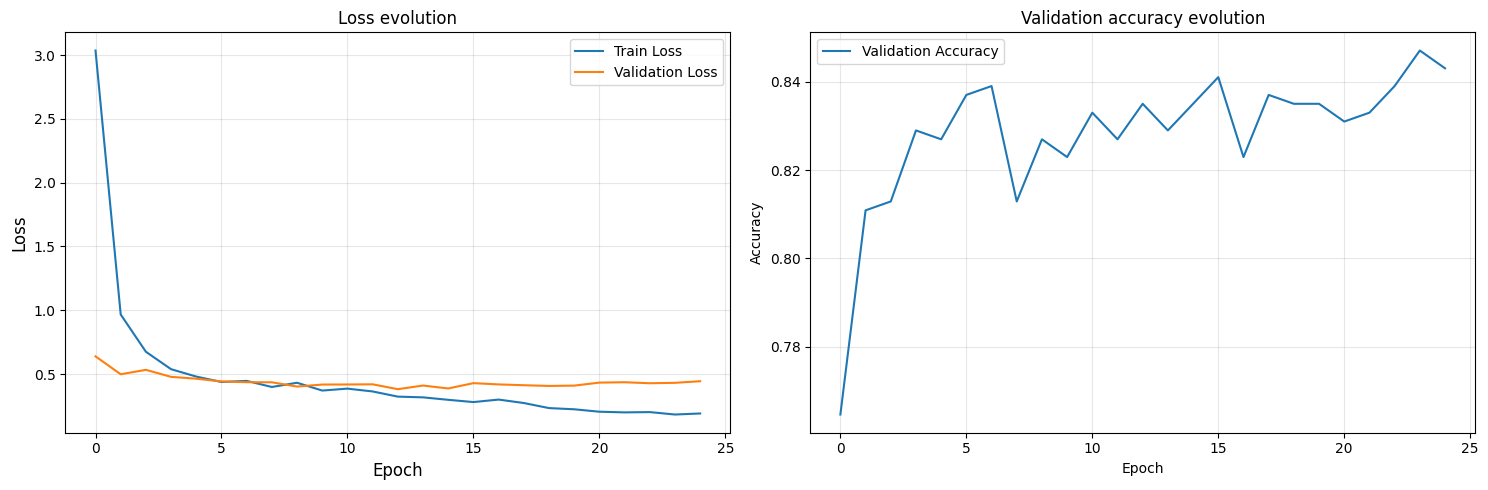

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss evolution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation accuracy evolution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluation

In [19]:
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

mlp = MLP(num_classes, input_size=299, dropout=0.3).to(device)
mlp.load_state_dict(torch.load("saved_models/mlp.pth"))
mlp.eval()

MLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=268203, out_features=200, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=100, out_features=3, bias=True)
  )
)

Test accuracy: 0.8551

Classification Report:
                 precision    recall  f1-score   support

   Lung_Opacity     0.8503    0.7764    0.8117       161
         Normal     0.7773    0.8962    0.8325       183
Viral Pneumonia     0.9784    0.8889    0.9315       153

       accuracy                         0.8551       497
      macro avg     0.8687    0.8538    0.8586       497
   weighted avg     0.8629    0.8551    0.8562       497



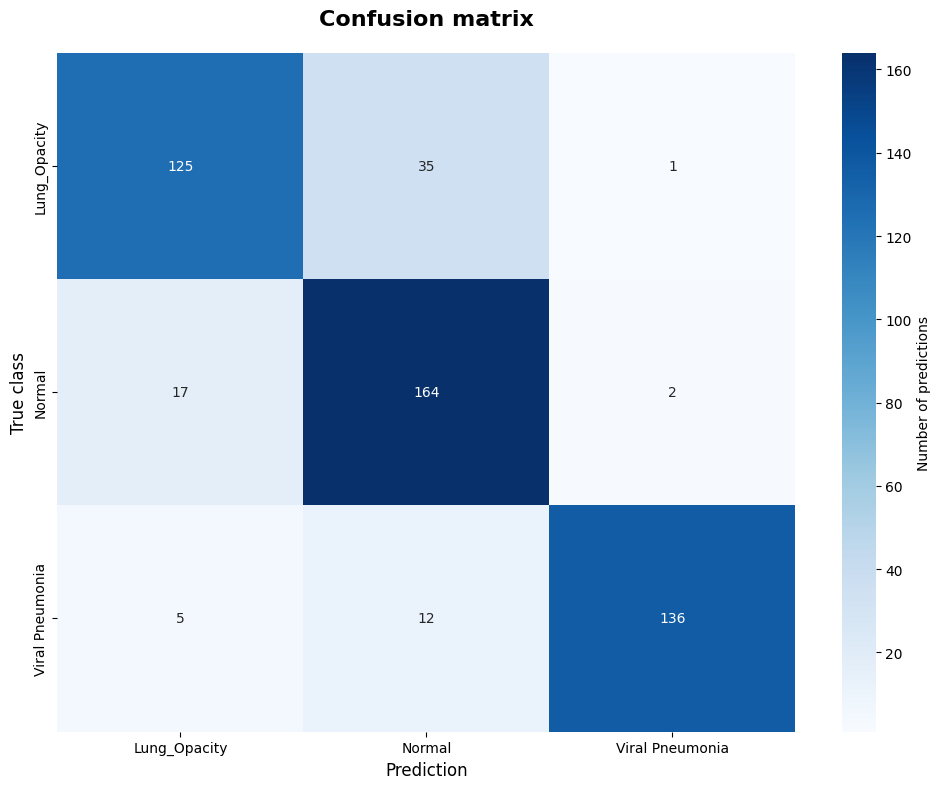

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        with autocast(device):
            outputs = mlp(images)
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.class_names, digits=4))


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dataset.class_names, 
            yticklabels=dataset.class_names,
            cbar_kws={'label': 'Number of predictions'})
plt.title('Confusion matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('True class', fontsize=12)
plt.tight_layout()
plt.show()